In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
plt.rcParams['figure.figsize'] = (15, 10)
from atom import *

On crée le marché et on ajoute deux assets.

In [3]:
m = Market()
m.add_asset(OrderBook("Apple"))
m.add_asset(OrderBook("Microsoft"))

In [4]:
ob = OrderBook("Apple")
t = Trader()
ob.add_order( LimitOrder("Apple",t,"ASK",110,1) ) 
ob.add_order( LimitOrder("Apple",t,"BID",110,1) ) 
o=LimitOrder("Apple",t,"BID",120,1)
print(len(ob.asks))
print(', '.join(map(str,ob.asks)))
print(ob)
print(', '.join(map(str,ob.match())))

1
ASK Apple at 110.00 x 1 from 1
Apple
['BID Apple at 110.00 x 1 from 1']
['BID Apple at 110.00 x 1 from 1']
1, 1, 110, 1


On lance 20 tours avec 100 agents et on stocke les résultats dans un DataFrame 'df'.

In [5]:
df = pd.DataFrame(columns=["asset", "time", "price"])
z = []
for i in range(2):
    t = ZITTrader(['Apple', 'Microsoft'])
    m.add_trader(t)
for i in range(20):
    p = m.run_once()
    if p != []:
        for x in p:
            df.loc[-1] = list(x)
            df.index = df.index + 1
            df = df.sort_index() 

On vérifie que 'df' contient bien les prix.

In [6]:
df.head(10)

,asset,time,price
0,Microsoft,19,94
1,Microsoft,18,94
2,Microsoft,17,94
3,Apple,16,59
4,Microsoft,15,78
5,Microsoft,13,85
6,Apple,10,55
7,Apple,9,50
8,Microsoft,5,91
9,Apple,4,71


On plotte les variations des prix.

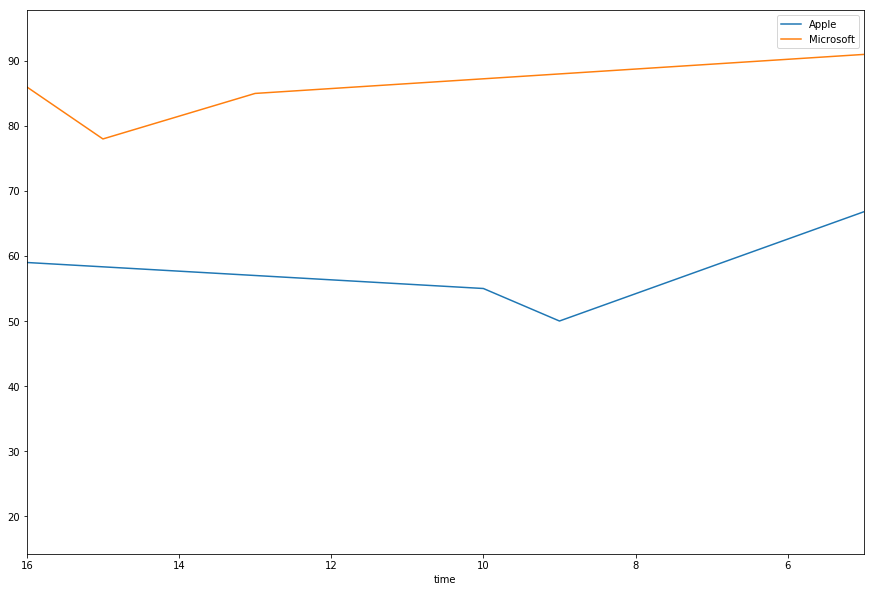

In [14]:
fig, ax = plt.subplots()
for label, grp in df.groupby('asset'):
    grp.plot(x = 'time', y = 'price', ax=ax, label=label)